In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import torch
from SDPC_PCB.Coding import ML_Lasso,ML_FISTA
import pickle
from SDPC_PCB.DataTools import LCN, whitening, z_score, mask, to_cuda, norm
import torch.nn.functional as f

from  SDPC_PCB.DataTools import DataBase, ssim
from SDPC_PCB.Network import LayerPC, Network

from SDPC_PCB.DataTools import DataBase
from SDPC_PCB.Monitor import Monitor
from SDPC_PCB.Optimizers import mySGD, myAdam
import torch.nn as nn
import torch
import time
import tensorboardX
import numpy as np

from tensorboardX import SummaryWriter
import pickle
from torchvision.transforms import ToTensor, Compose, RandomRotation
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim

import math

import matplotlib.pyplot as plt
from LogGabor import LogGaborFit


from matplotlib.patches import Rectangle,Circle
import matplotlib.lines as mlines
from torchvision.datasets import STL10

cmap=plt.get_cmap('Blues')
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.colors as colors

from matplotlib import cbook
from matplotlib.colors import Normalize, SymLogNorm
from numpy import ma

from math import pi
import scipy.ndimage.interpolation as interp
from scipy.stats import wilcoxon
from decimal import Decimal

In [2]:
class MidPointNorm(Normalize):    
    def __init__(self, midpoint=0, vmin=None, vmax=None, clip=False):
        Normalize.__init__(self,vmin, vmax, clip)
        self.midpoint = midpoint

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")       
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = ma.getmask(result)
                result = ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint            
            resdat[resdat>0] /= abs(vmax - midpoint)            
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = ma.array(resdat, mask=result.mask, copy=False)                

        if is_scalar:
            result = result[0]            
        return result

In [3]:
def show(img, dpi=50):
    npimg = img.numpy()
    plt.figure(dpi=dpi)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    return plt

grid_param = {'padding':1, 'normalize':True, 
                            'pad_value':1, 
                            'nrow':8}

In [4]:
def create_edge(center, angle, axis, scale=1, size_bar=1, c='b', w=1, flag=False):
    angle*=(math.pi/180)
    if flag == True:
        c='k'
    bar_length = 0.7
    x_coord = [center[0]-(scale*size_bar*bar_length/2)*np.cos(angle),center[0]+(scale*size_bar*bar_length/2)*np.cos(angle)]
    y_coord = [center[1]-(scale*size_bar*bar_length/2)*np.sin(angle),center[1]+(scale*size_bar*bar_length/2)*np.sin(angle)]
    line = mlines.Line2D(x_coord,y_coord,c=c,linewidth=w)
    axis.add_line(line)
    #circle = Circle(center, scale/10, ec="none", fc=c)
    #axis.add_patch(circle)
    return axis

def OrientationMap(matrix_ori, axis, scale=4, color_map=None, scale_map=None, coord_flag=None,w=1):
    
    if color_map is not None:
        #scaled_colormap = scale_color(color_map)
        scaled_colormap = color_map
    #    normalize = matplotlib.colors.Normalize(vmin=color_map.min(), vmax=color_map.max())
        
    axis.set_xlim(-2,matrix_ori.size(-2)*scale-2)
    axis.set_ylim(-2,matrix_ori.size(-1)*scale-2)
    #axis.axis('off')
    all_x_coor = torch.arange(0,matrix_ori.size(0)*scale,scale)
    all_y_coor = torch.arange((matrix_ori.size(1)-1)*scale,-1,-scale)
    
    for idx_y, y_coord in enumerate(all_y_coor):     
        for idx_x, x_coord in enumerate(all_x_coor):
            coord = (float(x_coord),float(y_coord))
            angle_or = float(matrix_ori[idx_y,idx_x])
            if color_map is not None:
                c = cmap(float(scaled_colormap[idx_y,idx_x]))
            else :
                c='darkgray'
            if scale_map is not None:
                size_bar = float(scale_map[idx_y,idx_x])
            else:
                size_bar=1
            if (idx_y,idx_x) == coord_flag:
                flag = True
            else : 
                flag = False
            axis = create_edge((float(x_coord),float(y_coord)),angle_or, scale=scale, axis=axis, \
                               w=w, size_bar=size_bar, c=c,flag=flag)
    
    return axis


def weighted_angle2(coeff, angle_rad):
    original_rotation_mat = angle_rad.unsqueeze(-1).unsqueeze(-1).expand_as(coeff)
    cos = torch.cos(2*original_rotation_mat).float()
    sin = torch.sin(2*original_rotation_mat).float()
    cos0 = torch.cos(original_rotation_mat).float()
    sin0 = torch.sin(original_rotation_mat).float()
    cos_weighted_0 = torch.mul(coeff,cos0).sum(dim=0)
    sin_weighted_0 = torch.mul(coeff,sin0).sum(dim=0)
    cos_weighted = torch.mul(coeff,cos).sum(dim=0)#.div(angle_rad.size(0))
    sin_weighted = torch.mul(coeff,sin).sum(dim=0)#.div(angle_rad.size(0))
    angle2t = 0.5*torch.atan2(sin_weighted,cos_weighted)
    norm = torch.sqrt((cos_weighted_0**2 + sin_weighted_0**2)).div(angle_rad.size(0))
    angle2t*=180/pi    
    return angle2t, norm

In [5]:
data_path = '../DataSet/STL10'

transform = Compose([
#                    RandomRotation((-45,45)),
                    ToTensor(),
                    to_cuda(),
                    whitening((96,96),f_0=0.5),
                    LCN(kernel_size=9,sigma=0.5,rgb=True),
                    z_score(),
                    mask((96,96))])

dataset = STL10(data_path, transform=transform, download=False, split='test')

DataBase = DataLoader(dataset, batch_size=40, shuffle=False, drop_last=True)

## Filtering out Low Frequency filters

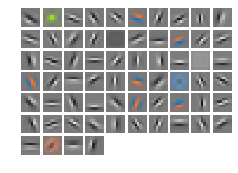

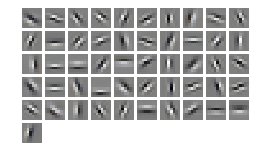

torch.Size([51, 3, 8, 8])


In [6]:
## selecting a preferend orientation
where = 'Savings/STL/'
model_name = 'STL_[0.4,1.6]_b=1.pkl'
name = model_name 

path = where + name
with open(path, 'rb') as file:
    out = pickle.load(file)
Net = out['Net']
grid_param = grid_param = {'padding':1, 'normalize':True, 
                            'pad_value':1, 
                            'nrow':10, 'scale_each':False}

img2 = make_grid(Net.layers[0].dico,**grid_param)
plot_L2 = show(img2.cpu())
plot_L2.show()


no_texture = [0,2,3,4,6,7,8,9,
              10,11,13,16,18,19,\
              20,21,22,23,24,25,26,27,29,\
              31,32,33,34,36,38,39,\
              40,41,42,43,44,46,48,49,\
              50,51,52,53,54,55,56,57,58,59,\
              60,62,63
             ]


img2 = make_grid(Net.layers[0].dico[no_texture],**grid_param)
plot_L2 = show(img2.cpu())
plot_L2.show()
print(Net.layers[0].dico[no_texture].size())

## Fit the dico and sort with orientation

In [7]:
parameterfile='https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
lg = LogGaborFit(parameterfile)
lg.set_size((12, 12))
grid_param = grid_param = {'padding':1, 'normalize':True, 
                            'pad_value':1, 
                            'nrow':10}
dico_to_fit = Net.layers[0].dico[no_texture]
nb_dico = dico_to_fit.size(0)
dico0 = f.upsample(dico_to_fit,(12,12),mode='bilinear')



dico0 = torch.mean(dico0,dim=1).unsqueeze(1)
dico0 /= norm(dico0)

dico0 = dico0.view(nb_dico,12*12)
dico0 = dico0.cpu().numpy()


dictx_fit_SDPC, dictx_fit_param_SDPC, name = lg.LogGaborFit_dictionary(dico0, whoswho=True, verbose=False)

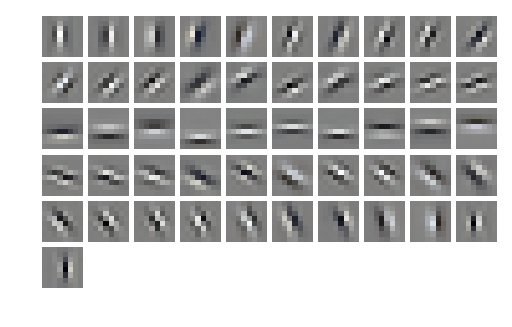

In [8]:
angle_list = torch.tensor(torch.tensor(dictx_fit_param_SDPC[:,2]*180/(np.pi)))
angle_list_rad = torch.tensor(torch.tensor(dictx_fit_param_SDPC[:,2]))
sorted_angle, idx_angle = torch.sort(angle_list, descending=True)
phase = torch.tensor(dictx_fit_param_SDPC[:,4])
sorted_phase = phase[idx_angle]*180/(np.pi)
#print(sorted_phase)
sorted_angle_rad, idx_angle_rad = torch.sort(angle_list_rad, descending=True)
#print(sorted_angle)
dico_sorted=Net.layers[0].dico[no_texture][idx_angle]
img2 = make_grid(dico_sorted,**grid_param)
plot_L2 = show(img2.cpu(),dpi=100)
plot_L2.show()
#print(sorted_angle_rad)

## Generate the sparse map

In [9]:
#save_simulation = False
#where = '../Simulation/SimuSTL/'
where = 'Savings/STL/'
model_name = 'STL_[0.4,1.6]_b=1.pkl'
#model_name = 'STL_20tr_l=[0.4,1.6]_b=1_learnv_v=6_[64,128]_sig=30_sz=8_stride=2.pkl'
#saving_path = 'Simulation/STL_FeedbackNOTraining_1200im.pkl'
#saving_path = 'Savings/STL/SimuFig4.pkl'

feedback_list = [0,1,2,3,4]
nb_batch = 30
nb_image= nb_batch*40
save_gamma_0 = torch.zeros(5,nb_image,64,45,45)
save_gamma_1 = torch.zeros(5,nb_image,128,38,38)
#if save_simulation == True:
for idx_model, kfb in enumerate(feedback_list):
    model_type = model_name[0:8]
    name = model_name
    print(name)

    path = where + name
    with open(path, 'rb') as file:
        out = pickle.load(file)
    Net = out['Net']
    for i in range(Net.nb_layers):
        Net.layers[i].b = kfb

    Loss = ML_Lasso(Net, [0.3,1.6])
    Pursuit = ML_FISTA(Net, Loss, max_iter=1000, th=5e-3, mode='eigen', accell=True)
    k=0
    for idx_batch, data in enumerate(DataBase):
        image_ori = data[0].cuda()
        batch = data[0].cuda()

        gamma, it, Loss_G, delta = Pursuit.coding(batch)
        save_gamma_0[idx_model,k:k+batch.size(0),:,:,:] = gamma[0][:,:,:,:]
        save_gamma_1[idx_model,k:k+batch.size(0),:,:,:] = gamma[1][:,:,:,:]
        k+=batch.size(0)
        if k >= nb_image:
            break

Exp = {'model_name': feedback_list,
        'gamma':[save_gamma_0,save_gamma_1]}

'''
    with open(saving_path, 'wb') as file:
        pickle.dump(Exp, file, pickle.HIGHEST_PROTOCOL)
            
else : 
    with open(saving_path, 'rb') as file:
        Exp = pickle.load(file)
'''

STL_[0.4,1.6]_b=1.pkl
STL_[0.4,1.6]_b=1.pkl
STL_[0.4,1.6]_b=1.pkl
STL_[0.4,1.6]_b=1.pkl
STL_[0.4,1.6]_b=1.pkl


"\n    with open(saving_path, 'wb') as file:\n        pickle.dump(Exp, file, pickle.HIGHEST_PROTOCOL)\n            \nelse : \n    with open(saving_path, 'rb') as file:\n        Exp = pickle.load(file)\n"

## Generate orientation map and activity map

In [10]:
##
#save_fig = False
save_result = True
saving_res_path = 'Savings/STL/OrientationMap.pkl'
torch.manual_seed(32)
save_gamma_0 = Exp['gamma'][0]
save_gamma_1 = Exp['gamma'][1]
model_name_list = Exp['model_name']
gamma_0 = save_gamma_0[:,:,no_texture,:,:][:,:,idx_angle,:,:].cuda()
gamma_1 = Exp['gamma'][1][:,:,no_texture,:,:][:,:,idx_angle,:,:]
dico0 = Net.layers[0].dico[no_texture][idx_angle]
cmap=plt.get_cmap('Blues')
ptch_size = 4
max_k = 10

if save_result == True:

    all_prefor_idx = np.arange(len(sorted_angle))
    all_prefor_angle = sorted_angle[all_prefor_idx]

    all_orientation_map = torch.zeros(len(all_prefor_idx),len(model_name_list),2*ptch_size+1,2*ptch_size+1).cuda()
    all_absolute_scale = torch.zeros(len(all_prefor_idx),len(model_name_list),2*ptch_size+1,2*ptch_size+1).cuda()
    all_relative_scale = torch.zeros(len(all_prefor_idx),len(model_name_list),2*ptch_size+1,2*ptch_size+1).cuda()
    all_unstructured = torch.zeros(len(model_name_list),2*ptch_size+1,2*ptch_size+1).cuda()
    unstructured = torch.zeros(len(model_name_list),len(sorted_angle),2*ptch_size+1,2*ptch_size+1).cuda()                               
    for idx_pref, idx_dico in enumerate(all_prefor_idx):
       
        for i in model_name_list:
            torch.manual_seed(32)
            patch_ac_all_image = torch.zeros(len(sorted_angle),2*ptch_size+1,2*ptch_size+1).cuda()
            patch_prob_all_image = torch.zeros(len(sorted_angle),2*ptch_size+1,2*ptch_size+1).cuda()

            adjusted_ac = torch.zeros(len(sorted_angle),2*ptch_size+1,2*ptch_size+1).cuda()
            adjusted_prob = torch.zeros(len(sorted_angle),2*ptch_size+1,2*ptch_size+1).cuda()
            
            for idx_image in range(nb_image):       

                patch_ac = torch.zeros(len(sorted_angle),2*ptch_size+1,2*ptch_size+1).cuda()
                patch_prob = torch.zeros(len(sorted_angle),2*ptch_size+1,2*ptch_size+1).cuda()
                normalized_SM = gamma_0[i,idx_image, idx_dico,:,:].clone()
                SM_resized = gamma_0[i,idx_image, idx_dico,ptch_size:-ptch_size,ptch_size:-ptch_size].clone()

                global_SM = gamma_0[i,idx_image, :,:,:].clone()
                global_SM_size = global_SM.view(len(sorted_angle),-1).size(1)
                global_SM_shuffled = gamma_0[i,idx_image, :,:,:].clone()

                for idx_xx in range(len(sorted_angle)):
                    global_SM_shuffled[idx_xx,:,:] = global_SM_shuffled[idx_xx,:,:].view(-1)[torch.randperm(global_SM_size)].view(global_SM.size(-2),global_SM.size(-1))


                unstructured_activ = global_SM_shuffled.unfold(1, 2*ptch_size+1,1).unfold(2, 2*ptch_size+1,1)
                unstructured_activ = unstructured_activ.contiguous().view(len(sorted_angle),-1,2*ptch_size+1,2*ptch_size+1).permute(1,0,2,3)
                unstructured_activ = unstructured_activ.mean(dim=0)
                unstructured_prob = (unstructured_activ!=0).float().mean(dim=0)


                value_max,idx_max = torch.topk(SM_resized.view(-1),max_k)
                idx_max_x = idx_max / SM_resized.size(1)
                idx_max_y = idx_max % SM_resized.size(1)
                idx_max_x += ptch_size
                idx_max_y += ptch_size

                for idx_k in range(max_k):
                    patch_global = global_SM[:,idx_max_x[idx_k]-ptch_size:idx_max_x[idx_k]+ptch_size+1,idx_max_y[idx_k]-ptch_size:idx_max_y[idx_k]+ptch_size+1]
                    patch_ac += patch_global
                    patch_prob += (patch_global!=0).float()
                patch_ac_cont = patch_ac/max_k
                patch_prob_cont = patch_prob/max_k
                adjusted_ac += (patch_ac_cont.div(unstructured_activ) - 1)
                check_nan = adjusted_ac != adjusted_ac

                patch_ac_all_image += patch_ac_cont
                patch_prob_all_image += patch_prob_cont
                adjusted_prob += patch_prob_cont.div(unstructured_prob)

            patch_ac_all_image /= nb_image
            patch_prob_all_image /= nb_image
            
            adjusted_ac /= nb_image
            adjusted_prob /= nb_image
            
            adj = adjusted_ac.clone().view(len(sorted_angle),-1)
            unstructured[i,:,:,:] += adj[:, torch.randperm(adj.size(1))].view(adjusted_ac.size())
            angle_map_2t, norm = weighted_angle2(adjusted_ac, sorted_angle_rad.cuda())

            all_orientation_map[idx_pref,i,:,:] = angle_map_2t 
            all_absolute_scale[idx_pref,i,:,:] = norm
            all_relative_scale[idx_pref,i,:,:] = all_absolute_scale[idx_pref,i,:,:]/all_absolute_scale[idx_pref,0,:,:]
        
            
    unstructured/= (len(all_prefor_idx))
    #unstructured-=unstructured.mean(dim=1).unsqueeze(dim=1)
    
    for i in model_name_list:
        angle_map_unstruct, norm_unstructured = weighted_angle2(unstructured[i,:,:,:], sorted_angle_rad.cuda())
        all_unstructured[i,:,:] = angle_map_unstruct
    all_result = {'or_map' : all_orientation_map.cpu(),
                'abs_activity' : all_absolute_scale.cpu(),
                'rel_activity' : all_relative_scale.cpu(),
                'angle_deg': all_prefor_angle.cpu(),
                 'unstruct_or': all_unstructured.cpu()}

    with open(saving_res_path, 'wb') as file:
        pickle.dump(all_result, file, pickle.HIGHEST_PROTOCOL)
    
else : 
    with open(saving_res_path, 'rb') as file:
         all_result = pickle.load(file)            
        

## Fig 5

pref_orientation=14.00 -- idx:30.92675807926285 



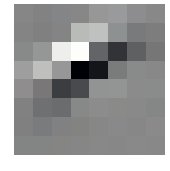

orientation map absolute scale fb=0 pref_orientation=30.93


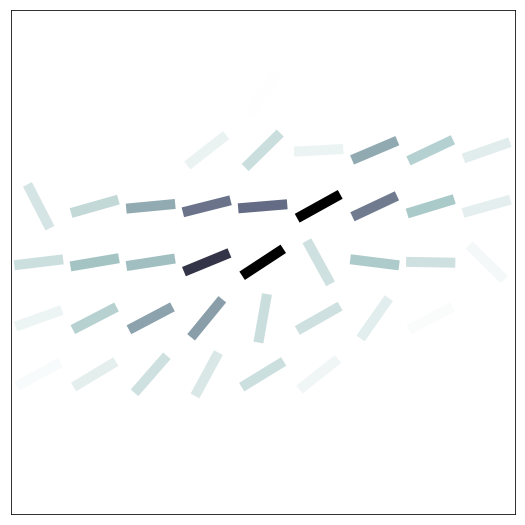

orientation map absolute scale fb=1 pref_orientation=30.93


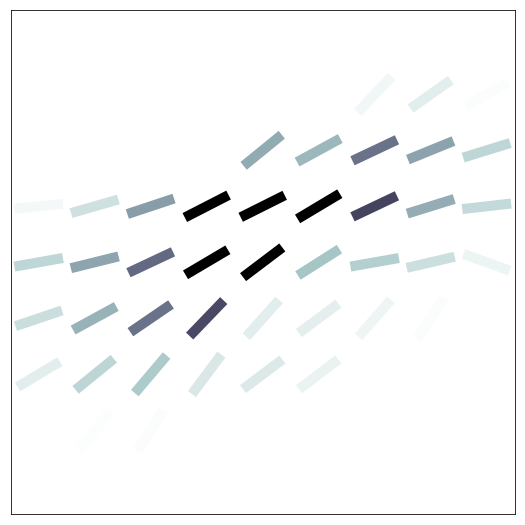

In [11]:
#[14,22]
from matplotlib.ticker import LogLocator
all_absolute_scale = all_result['abs_activity'].cuda()

all_orientation_map = all_result['or_map'].cuda()
all_angle =  all_result['angle_deg'].cuda()
selected_or = [14] #np.arange(len(all_angle)) #[14]#np.arange(len(all_angle))[14,34]#
save_fig = False
fig_number = ['a','b']
for idx_pref in selected_or: 
    print('pref_orientation={0:.2f} -- idx:{1} \n'.format(idx_pref,all_angle[idx_pref]))
    img2 = make_grid(dico0[idx_pref:idx_pref+1,:,:,:],**grid_param)
    plot_L2 = show(img2.cpu())

    if save_fig == True:
        plot_L2.savefig('Savings/Fig/Fig5/Fig5_filter.png', \
                            bbox_inches='tight', pad_inches = 0, dpi= 400)
    plot_L2.show()
    for i in range(2):
        #cmap=plt.get_cmap('pink_r')
        cmap=plt.get_cmap('bone_r')
        print('orientation map absolute scale fb={0} pref_orientation={1:.2f}'.format(i,all_angle[idx_pref]))
        abs_scale = all_absolute_scale[idx_pref,i,:,:]#.div(absolute_scale[i,:,:].max())
        lognorm = colors.Normalize(vmin=0.3, vmax=0.8)
        colorscale = lognorm(abs_scale.cpu().numpy())
        fig = plt.figure(frameon=True, figsize=(7,7))
        currentAxis = plt.Axes(fig, [0., 0., 1., 1.])
        currentAxis = OrientationMap(all_orientation_map[idx_pref,i,:,:],currentAxis, color_map=colorscale,w=10)

        fig.add_axes(currentAxis)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=lognorm)
        sm.set_array([])
        '''
        cb = fig.colorbar(sm, ax=currentAxis, extend='both',location='bottom',ticks=[0.3,0.4,0.5,0.6,0.7,0.8])


        cb.ax.set_xticklabels(labels=['0.3','0.4','0.5','0.6','0.7','0.8'] ,fontsize=15)
        
        #cb.set_label('neural response ' +r'($\mid\bar{a}\mid$)',fontsize=15, labelpad=15)
        cb.ax.set_title('neural response ' +r'($\mid\bar{a}\mid$)',fontsize=15,pad=15)
        '''
        plt.tick_params(
            axis='x',       # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,
            right='off', left='off',# ticks along the top edge are off
            labelbottom=False,
            labelleft='off') 
        plt.tick_params(
            axis='y',       # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,  
            right='off', left='off',# ticks along the top edge are off
            labelbottom=False,
            labelleft='off') 
        plt.tight_layout()
        if save_fig == True:
            '''
            plt.savefig('Fig4_V2/abs_legend.png', \
                        bbox_inches='tight', pad_inches = 0, dpi= 400)
            '''
            plt.savefig('Savings/Fig/Fig5/Fig5{0}.png'.format(fig_number[i]), \
                bbox_inches='tight', pad_inches = 0, dpi= 400)
            
        plt.show()
            
        

## Fig 6

In [12]:
def co_circular_AF(orientation_map,ptch_size):
    orientation_rad = (orientation_map[ptch_size,ptch_size])*pi/180
    x_p = torch.arange(-ptch_size,ptch_size+1,1).unsqueeze(0).expand_as(orientation_map).float().cuda()
    y_p = torch.arange(ptch_size,-(ptch_size+1),-1).unsqueeze(-1).expand_as(orientation_map).float().cuda()
    cos = torch.cos(orientation_rad+pi/2)
    sin = torch.sin(orientation_rad+pi/2)
    tan = torch.tan(orientation_rad+pi/2)
    x_c = 0.5*(cos*(x_p**2 + y_p**2)).div(cos*x_p + sin*y_p)
    y_c = tan*x_c
    d_center = torch.sqrt(x_p**2 + y_p**2)
    
    Theta_co = torch.atan((y_p-y_c).div(x_p-x_c)) + pi/2
    Theta_co*= 180/pi
    r = x_c*torch.sqrt(1+tan**2)
    
    #print(Theta_co[Theta_co!=Theta_co])
    Theta_co[Theta_co!=Theta_co] = orientation_map[ptch_size,ptch_size]
    return Theta_co, r, d_center

def circular_diff(angle1,angle2):
    angle1 *= pi/180
    angle2 *= pi/180
    out = torch.atan2(torch.sin(angle1-angle2),torch.cos(angle1-angle2))
    out*= 180/pi
    return out

def normalize_angle(test):
    out = test.clone()
    out[test<-90] = test[test<-90] + 180
    out[test>90] = test[test>90] - 180
    return out

all_orientation_map = all_result['or_map'].cuda()
all_angle =  all_result['angle_deg'].cuda()

all_unstructured = all_result['unstruct_or'].cuda()

coli_R1 = torch.zeros(len(all_angle),len(model_name_list))
coli_R2 = torch.zeros(len(all_angle),len(model_name_list))
cocir_R1 = torch.zeros(len(all_angle),len(model_name_list))
cocir_R2 = torch.zeros(len(all_angle),len(model_name_list))
coli_unstruct = torch.zeros(len(all_angle),len(model_name_list))
cocir_unstruct = torch.zeros(len(all_angle),len(model_name_list))



coli_R1_V2 = torch.zeros(len(all_angle),len(model_name_list))
coli_R2_V2 = torch.zeros(len(all_angle),len(model_name_list))
cocir_R1_V2 = torch.zeros(len(all_angle),len(model_name_list))
cocir_R2_V2 = torch.zeros(len(all_angle),len(model_name_list))

unstruct_coli_R1 = torch.zeros(len(all_angle),len(model_name_list))
unstruct_coli_R2 = torch.zeros(len(all_angle),len(model_name_list))
unstruct_cocir_R1 = torch.zeros(len(all_angle),len(model_name_list))
unstruct_cocir_R2 = torch.zeros(len(all_angle),len(model_name_list))

for idx_pref in range(len(all_angle)) : 
#for idx_pref in angle_list : 
    preferred = torch.zeros_like(all_orientation_map[idx_pref,i,:,:])
    preferred[ptch_size,ptch_size] = all_angle[idx_pref]
    Theta_co,r,d_center = co_circular_AF(preferred,ptch_size)
    for i in range(5):
        original_map = all_orientation_map[idx_pref,i,:,:]
        unstruct_map = all_unstructured[i]
        ptch_size = 4
        
        R1 =  r.abs().div(d_center)>=0.8
        R1[ptch_size,ptch_size] = 0
        nb_R1 = R1.sum()
        R2 = r.abs().div(d_center)<0.8
        R2[ptch_size-1:ptch_size+2,ptch_size-1:ptch_size+2]=0
        
        R1 =  r.abs().div(d_center)>=1
        nb_R1 = R1.sum()
        
        R2 = r.abs().div(d_center)<1
        nb_R2 = R2.sum()
        
        unstruct_coli = circular_diff(normalize_angle(unstruct_map),normalize_angle(original_map[ptch_size,ptch_size]))
        unstruct_coli = torch.abs(unstruct_coli)%90
        
        colinearity2 = circular_diff(normalize_angle(original_map),normalize_angle(original_map[ptch_size,ptch_size]))
        colinearity2 = torch.abs(colinearity2)%90
        
        
        
        unstruct_cocir = circular_diff(normalize_angle(unstruct_map),normalize_angle(Theta_co))
        unstruct_cocir = torch.abs(unstruct_cocir)%90
        
        co_circularity2 = circular_diff(normalize_angle(original_map),normalize_angle(Theta_co))
        co_circularity2 = torch.abs(co_circularity2)%90
        
    
        ## colinearity region 1
        coli_R1_V2[idx_pref,i] = colinearity2[R1].sum()/nb_R1
        ## cocircularity region 1

        cocir_R1_V2[idx_pref,i] = co_circularity2[R1].sum()/nb_R1
        ## colinearity region 2
        coli_R2_V2[idx_pref,i] = colinearity2[R2].sum()/nb_R2
        cocir_R2_V2[idx_pref,i] = co_circularity2[R2].sum()/nb_R2
        
        unstruct_coli_R1[idx_pref,i] = unstruct_coli[R1].sum()/nb_R1
        unstruct_coli_R2[idx_pref,i] = unstruct_coli[R2].sum()/nb_R2
        unstruct_cocir_R1[idx_pref,i] = unstruct_cocir[R1].sum()/nb_R1
        unstruct_cocir_R2[idx_pref,i] = unstruct_cocir[R2].sum()/nb_R2
        

relative_coli_R1 = coli_R1_V2/coli_R1_V2[:,0].unsqueeze(1)
relative_coli_R2 = coli_R2_V2/coli_R2_V2[:,0].unsqueeze(1)

relative_cocir_R1 = cocir_R1_V2/cocir_R1_V2[:,0].unsqueeze(1)
relative_cocir_R2 = cocir_R2_V2/cocir_R2_V2[:,0].unsqueeze(1)
relative_coli_R1 = 1/relative_coli_R1
relative_coli_R2 = 1/relative_coli_R2
relative_cocir_R1 = 1/relative_cocir_R1
relative_cocir_R2 = 1/relative_cocir_R1

relative_coli_R1_ref = unstruct_coli_R1/coli_R1_V2
relative_coli_R2_ref = unstruct_coli_R2/coli_R2_V2
relative_cocir_R1_ref = unstruct_cocir_R1/cocir_R1_V2
relative_cocir_R2_ref = unstruct_cocir_R2/cocir_R2_V2


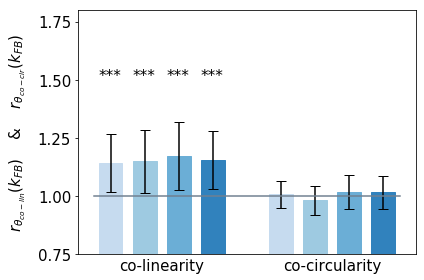

[6. 4.]


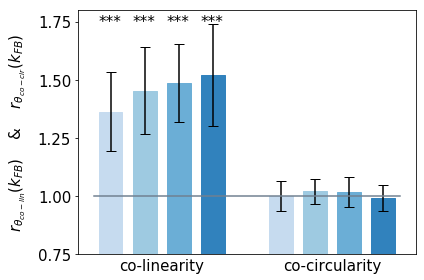

In [13]:
#lbda_list_lbda2 = [1,1.2,1.4,1.6,1.8]
#N = res_HiLa_lbda2['loss'].shape[0]
save_fig = False
cmap1=plt.get_cmap('tab20c')
color_no_fb = cmap1(21)
color_fb=[cmap1(3),cmap1(2),cmap1(1),cmap1(0)]

#color_no_fb = cmap1(21)
#color_fb=['slategrey', cmap1(3),cmap1(2),cmap1(1),cmap1(0)]

val_range = (0.75,1.8)
ticks_val = [0.75,1,1.25,1.50,1.75]
#ticks_val = [0,1,2,3,4,5,6,7]

position_coli_R1 = [0,1,2,3]
position_coci_R1 = [5,6,7,8]
#position_coci_R1 = [7,8,9,10,11]

labels = ['$k_{FB}=1$','$k_{FB}=2$','$k_{FB}=3$','$k_{FB}=4$']

rm_ouli = np.arange(unstruct_coli_R1.size(0))
rm_ouli = np.delete(rm_ouli,-3,0)


relative_coli_R1_ref = unstruct_coli_R1/coli_R1_V2
rel_int_coli_R1 = relative_coli_R1_ref/relative_coli_R1_ref[:,0].unsqueeze(1)
rel_int_coli_R1 = rel_int_coli_R1[rm_ouli,:][:,1:]
#print(rel_int_coli_R1)
med_coli_R1 = rel_int_coli_R1.median(dim=0)[0]

err_coli_R1 = (rel_int_coli_R1 - rel_int_coli_R1.median(dim=0)[0].unsqueeze(0)).abs()
err_coli_R1 = err_coli_R1.median(dim=0)[0]


relative_coli_R2_ref = unstruct_coli_R2/coli_R2_V2
rel_int_coli_R2 = relative_coli_R2_ref/relative_coli_R2_ref[:,0].unsqueeze(1)
rel_int_coli_R2 = rel_int_coli_R2[rm_ouli,:][:,1:]
med_coli_R2 = rel_int_coli_R2.median(dim=0)[0]
err_coli_R2 = (rel_int_coli_R2 - rel_int_coli_R2.median(dim=0)[0].unsqueeze(0)).abs()
err_coli_R2 = err_coli_R2.median(dim=0)[0]

relative_cocir_R1_ref = unstruct_cocir_R1/cocir_R1_V2
rel_int_cocir_R1 = relative_cocir_R1_ref/relative_cocir_R1_ref[:,0].unsqueeze(1)
rel_int_cocir_R1 = rel_int_cocir_R1[rm_ouli,:][:,1:]
med_cocir_R1 = rel_int_cocir_R1.median(dim=0)[0]
err_cocir_R1 = (rel_int_cocir_R1 - rel_int_cocir_R1.median(dim=0)[0].unsqueeze(0)).abs()
err_cocir_R1 = err_cocir_R1.median(dim=0)[0]

relative_cocir_R2_ref = unstruct_cocir_R2/cocir_R2_V2
rel_int_cocir_R2 = relative_cocir_R2_ref/relative_cocir_R2_ref[:,0].unsqueeze(1)
rel_int_cocir_R2 = rel_int_cocir_R2[rm_ouli,:][:,1:]
med_cocir_R2 = rel_int_cocir_R2.median(dim=0)[0]
err_cocir_R2 = (rel_int_cocir_R2 - rel_int_cocir_R2.median(dim=0)[0].unsqueeze(0)).abs()
err_cocir_R2 = err_cocir_R2.median(dim=0)[0]


#fig = plt.figure(figsize=(6,5))
histo_coli_R1 = plt.bar(position_coli_R1, med_coli_R1, yerr=err_coli_R1.cpu().numpy(), capsize=5,
                    width=0.7) #color=cmap1(1),edgecolor=cmap2(0))

histo_coci_R1 = plt.bar(position_coci_R1, med_cocir_R1 , yerr=err_cocir_R1.cpu().numpy(), capsize=5,
                    width=0.7)


for i in range(4):
    histo_coli_R1[i].set_color(color_fb[i])
    histo_coci_R1[i].set_color(color_fb[i])
    histo_coli_R1[i].set_label(labels[i])

plt.ylim(val_range)

plt.plot([-0.5,8.5], [1, 1], color='slategrey',label='         '+r'baseline'+ '\n (marginal measure)')
#plt.xlabel('feedback strenght '+ r'($k_{FB}$)', fontsize=15, labelpad=10)

plt.xticks([1.5,6.5], ['co-linearity','co-circularity'] , fontsize=15)
plt.yticks(ticks_val, fontsize=15)
plt.tick_params(axis='x', length=0)
#plt.ylabel('Relative co-linearity and \n co-circulariy w.r.t. to '+r'$k_{FB}=0$', fontsize=15, labelpad=10)
plt.ylabel(r'$r_{\theta_{co-lin}}}$' + r'$(k_{FB})$' + '    &    ' + r'$r_{\theta_{co-cir}}}$' + r'$(k_{FB})$', fontsize=15, labelpad=10)
for  sig_pos in position_coli_R1 : 
    plt.text(sig_pos-0.35,1.5,'***',fontsize=15)
plt.tight_layout()
#plt.legend(loc='lower center',bbox_to_anchor=(0.5, -0.5),ncol=6,fontsize=15)
if save_fig == True:
    
    plt.savefig('Savings/Fig/Fig6/Fig6a.png', bbox_inches = 'tight', pad_inches = 0, dpi= 400)
    
    #''''''
    #plt.savefig('Fig5_V2/cocir_coli_legend.png', bbox_inches = 'tight', pad_inches = 0.1, dpi= 400)
    #''''''


plt.show()


#fig = plt.figure(figsize=(6,5))
position_coli_R2 = [0,1,2,3]
position_coci_R2 = [5,6,7,8]
#position_coci_R2 = [7,8,9,10,11]

histo_coli_R2 = plt.bar(position_coli_R2, med_coli_R2 , yerr=err_coli_R2.cpu().numpy(), capsize=5,
                    width=0.7) #color=cmap1(1),edgecolor=cmap2(0))

histo_coci_R2 = plt.bar(position_coci_R2, med_cocir_R2 , yerr=err_cocir_R2.cpu().numpy(), capsize=5,
                    width=0.7)

for i in range(4):
    histo_coli_R2[i].set_color(color_fb[i])
    histo_coci_R2[i].set_color(color_fb[i])
    histo_coli_R2[i].set_label(labels[i])

plt.ylim(val_range)

plt.plot([-0.5,8.5], [1, 1], color='slategrey',label=r'baseline')
#plt.xlabel('feedback strenght '+ r'($k_{FB}$)', fontsize=15, labelpad=10)

plt.xticks([1.5,6.5], ['co-linearity','co-circularity'] , fontsize=15)
plt.yticks(ticks_val, fontsize=15)
plt.tick_params(axis='x', length=0)
#plt.ylabel(r'$r_{co-lin}^{k_{FB}}$' + '   &   ' + r'$r_{co-cir}^{k_{FB}} $', fontsize=15, labelpad=10)
#plt.ylabel('Relative co-linearity and \n co-circulariy w.r.t. to '+r'$k_{FB}=0$' , fontsize=15, labelpad=10)
plt.ylabel(r'$r_{\theta_{co-lin}}}$' + r'$(k_{FB})$' + '    &    ' + r'$r_{\theta_{co-cir}}}$' + r'$(k_{FB})$', fontsize=15, labelpad=10)
for  sig_pos in position_coli_R2 : 
    plt.text(sig_pos-0.35,1.73,'***',fontsize=15)
plt.tight_layout()
if save_fig == True:
    plt.savefig('Savings/Fig/Fig6/Fig6b.png', bbox_inches = 'tight', pad_inches = 0, dpi= 400)

fig = plt.gcf()
size = fig.get_size_inches()
print(size)
plt.show()



### Stastistical test Fig 6 : relative colinearity and cocir > baseline

In [14]:
print('SIGNIFICATIVITY R1 coli acti \n')
'''
print('distribution')

print(dist)
for i in range(5):
    out = plt.hist(rel_activ_R1[:,i],bins=50)
    plt.ylim(0,10)
    plt.show()
'''
to_print=''
baseline=torch.ones(rel_int_coli_R1.size(0))
for i in range(4):
    test = wilcoxon(rel_int_coli_R1[:,i],baseline,alternative='greater' )
    to_print+='fb={0}/baseline = {1:0.2E} -- '.format(i+1,Decimal(test[1]))
    to_print+='\n'
print(to_print)

print('SIGNIFICATIVITY R2 coli acti \n')
to_print=''
baseline=torch.ones(rel_int_coli_R2.size(0))
for i in range(4):
    test = wilcoxon(rel_int_coli_R2[:,i],baseline,alternative='greater' )
    to_print+='fb={0}/baseline = {1:0.2E} -- '.format(i+1,Decimal(test[1]))
    to_print+='\n'
print(to_print)

print('SIGNIFICATIVITY R1 cocir acti \n')
to_print=''
baseline=torch.ones(rel_int_cocir_R1.size(0))
for i in range(4):
    test = wilcoxon(rel_int_cocir_R1[:,i],baseline,alternative='greater' )
    to_print+='fb={0}/baseline = {1:0.2E} -- '.format(i+1,Decimal(test[1]))
    to_print+='\n'
print(to_print)

print('SIGNIFICATIVITY R2 cocir acti \n')
to_print=''
baseline=torch.ones(rel_int_cocir_R2.size(0))
for i in range(4):
    test = wilcoxon(rel_int_cocir_R2[:,i],baseline,alternative='greater' )
    to_print+='fb={0}/baseline = {1:0.2E} -- '.format(i+1,Decimal(test[1]))
    to_print+='\n'
print(to_print)


SIGNIFICATIVITY R1 coli acti 

fb=1/baseline = 4.15E-7 -- 
fb=2/baseline = 1.24E-7 -- 
fb=3/baseline = 9.55E-8 -- 
fb=4/baseline = 8.16E-8 -- 

SIGNIFICATIVITY R2 coli acti 

fb=1/baseline = 5.77E-10 -- 
fb=2/baseline = 4.82E-10 -- 
fb=3/baseline = 4.82E-10 -- 
fb=4/baseline = 4.53E-10 -- 

SIGNIFICATIVITY R1 cocir acti 

fb=1/baseline = 1.39E-1 -- 
fb=2/baseline = 4.71E-1 -- 
fb=3/baseline = 5.90E-1 -- 
fb=4/baseline = 4.63E-1 -- 

SIGNIFICATIVITY R2 cocir acti 

fb=1/baseline = 4.56E-1 -- 
fb=2/baseline = 8.01E-2 -- 
fb=3/baseline = 1.20E-1 -- 
fb=4/baseline = 2.13E-1 -- 



## Fig 7

pref_orientation=13.00 -- idx:42.584484083220936 



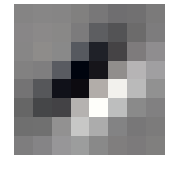

orientation map relative scale fb=3 pref_orientation=13


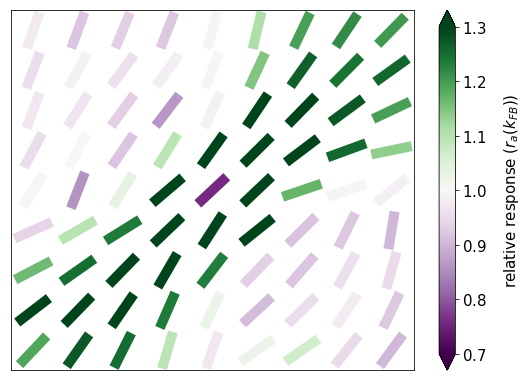

In [15]:

from matplotlib.ticker import LogLocator
all_relative_scale = all_result['rel_activity'].cuda()
all_orientation_map = all_result['or_map'].cuda()
all_angle =  all_result['angle_deg'].cuda()
selected_or = [13]
save_fig = False
for idx_pref in selected_or: 
    print('pref_orientation={0:.2f} -- idx:{1} \n'.format(idx_pref,all_angle[idx_pref]))
    img2 = make_grid(dico0[idx_pref:idx_pref+1,:,:,:],**grid_param)
    plot_L2 = show(img2.cpu())

    if save_fig == True:
        plot_L2.savefig('Savings/Fig/Fig7/Fig7_filter.png', \
                            bbox_inches='tight', pad_inches = 0, dpi= 400)
    plot_L2.show()
    if i != 0:
            #cmap=plt.get_cmap('bwr_r')
            cmap=plt.get_cmap('PRGn')
            print('orientation map relative scale fb={0} pref_orientation={1}'.format(i,idx_pref))
            rel_scale = all_relative_scale[idx_pref,i,:,:]
            
            renorm2 = MidPointNorm(midpoint=1,vmin=0.7,vmax=1.3)
            colorscale = renorm2(rel_scale.cpu().numpy())
            
            
            
            fig = plt.figure(frameon=True, figsize=(7,5))
            currentAxis = plt.Axes(fig, [0., 0., 1., 1.])
            currentAxis = OrientationMap(all_orientation_map[idx_pref,i,:,:],currentAxis, color_map=colorscale,w=10)
            #currentAxis.set_axis_off()
            fig.add_axes(currentAxis)
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=renorm2)
            sm.set_array([])
            cb = plt.colorbar(sm,extend='both',location='right')
            cb.ax.set_yticklabels(labels=[r'$0.7$',r'$0.8$',r'$0.9$',r'$1.0$',r'$1.1$',r'$1.2$',r'$1.3$'],fontsize=15)
            cb.set_label('relative response ' + r'($r_{a}(k_{FB})$)',fontsize=15, labelpad=15)
            plt.tick_params(
            axis='x',       # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,
            right='off', left='off',# ticks along the top edge are off
            labelbottom=False,
            labelleft='off')
            
            plt.tick_params(
            axis='y',       # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,  
            right='off', left='off',# ticks along the top edge are off
            labelbottom=False,
            labelleft='off') 
            #cb.set_label(size=15)
            plt.tight_layout()
            
            if save_fig == True:

                plt.savefig('Savings/Fig/Fig7/Fig7.png', \
                            bbox_inches='tight', pad_inches = 0.5, dpi= 400)
                '''
                plt.savefig('Fig6_V2/AF_relative.png',\
                            bbox_inches = 'tight', pad_inches = 0, dpi= 400)
                '''
            plt.show()

## Fig 8

In [16]:
all_orientation_map = all_result['or_map'].cuda()
all_angle =  all_result['angle_deg'].cuda()

activ_R1 = torch.zeros(len(all_angle),len(model_name_list))
activ_R2 = torch.zeros(len(all_angle),len(model_name_list))
activ_R3 = torch.zeros(len(all_angle),len(model_name_list))
abs_activity = all_result['abs_activity'].cuda()
rel = all_result['rel_activity'].cuda()
rel_bis = torch.zeros(len(all_angle),len(model_name_list))
for idx_pref in range(len(all_angle)):
    preferred = torch.zeros_like(original_map)
    preferred[ptch_size,ptch_size] = all_angle[idx_pref]
    Theta_co,r,d_center = co_circular_AF(preferred,ptch_size)
    for i in range(5):
        original_map = all_orientation_map[idx_pref,i,:,:]
        ptch_size = 4
        R1 =  r.abs().div(d_center)>=0.8
        R1[ptch_size,ptch_size] = 0
        nb_R1 = R1.sum()
        R2 = r.abs().div(d_center)<0.8

        R2[ptch_size-1:ptch_size+2,ptch_size-1:ptch_size+2]=0
        nb_R2 = R2.sum()
        activ_R1[idx_pref,i] = abs_activity[idx_pref,i,][R1].sum()/nb_R1
        activ_R2[idx_pref,i] = abs_activity[idx_pref,i,][R2].sum()/nb_R2
        activ_R3[idx_pref,i] = abs_activity[idx_pref,i,ptch_size,ptch_size]
        
rel_activ_R1 = activ_R1/activ_R1[:,0].unsqueeze(1)
rel_activ_R2 = activ_R2/activ_R2[:,0].unsqueeze(1)
rel_activ_R3 = activ_R3/activ_R3[:,0].unsqueeze(1)

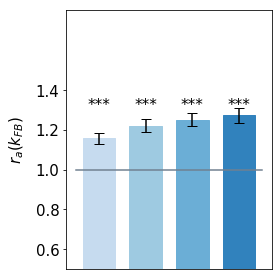

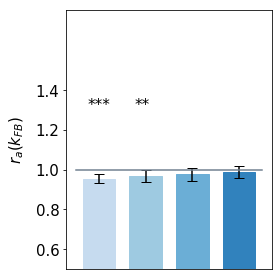

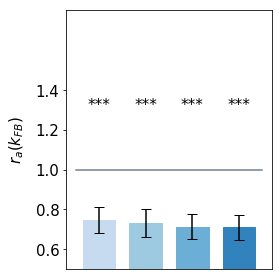

In [17]:
#lbda_list_lbda2 = [1,1.2,1.4,1.6,1.8]
#N = res_HiLa_lbda2['loss'].shape[0]
save_fig = False
cmap1=plt.get_cmap('tab20c')
color_no_fb = cmap1(21)
color_fb=[cmap1(3),cmap1(2),cmap1(1),cmap1(0)]
val_range = (0.5,1.8)
ticks_val = [0.6,0.8,1,1.2,1.4]
position = [0,1,2,3]
#position_coci_R1 = [6,7,8,9]

labels = ['$k_{FB}=1$','$k_{FB}=2$','$k_{FB}=3$','$k_{FB}=4$']

mean_activ_R1 = rel_activ_R1.median(dim=0)[0][1:]
err_activ_R1 = (rel_activ_R1 - rel_activ_R1.median(dim=0)[0].unsqueeze(0)).abs()
err_activ_R1 = err_activ_R1.median(dim=0)[0][1:]


mean_activ_R2 = rel_activ_R2.median(dim=0)[0][1:]
err_activ_R2 = (rel_activ_R2 - rel_activ_R2.median(dim=0)[0].unsqueeze(0)).abs()
err_activ_R2 = err_activ_R2.median(dim=0)[0][1:]

mean_activ_R3 = rel_activ_R3.median(dim=0)[0][1:]
err_activ_R3 = (rel_activ_R3 - rel_activ_R3.median(dim=0)[0].unsqueeze(0)).abs()
err_activ_R3 = err_activ_R3.median(dim=0)[0][1:]

### Region R1
fig = plt.figure(figsize=(4,4))
histo_activ_R1 = plt.bar(position, mean_activ_R1, yerr=err_activ_R1.cpu().numpy(), capsize=5,
                    width=0.7) #color=cmap1(1),edgecolor=cmap2(0))


for i in range(4):
    histo_activ_R1[i].set_color(color_fb[i])
    histo_activ_R1[i].set_label(labels[i])

plt.ylim(val_range)

plt.plot([-0.5,3.5], [1, 1], color='slategrey',label=r'baseline '+'$(k_{FB}=0)$')
#plt.xlabel('feedback strenght '+ r'($k_{FB}$)', fontsize=15, labelpad=10)

for  sig_pos in position : 
    plt.text(sig_pos-0.25,1.3,'***',fontsize=15)
    
plt.xticks([])
plt.yticks(ticks_val, fontsize=15)
plt.tick_params(axis='x', length=0)
plt.ylabel(r'$r_{a}(k_{FB})$', fontsize=15, labelpad=10)

plt.tight_layout()
#plt.legend(loc='lower center',bbox_to_anchor=(0.5, -0.5),ncol=5,fontsize=15)
if save_fig == True:
    
    plt.savefig('Savings/Fig/Fig8/Fig8a.png', bbox_inches = 'tight', pad_inches = 0, dpi= 400)
    
    #'''
   # plt.savefig('Fig5_V2/cocir_coli_legend.png', bbox_inches = 'tight', pad_inches = 0, dpi= 400)
   # '''
plt.show()


### Region R2
fig = plt.figure(figsize=(4,4))
histo_activ_R2 = plt.bar(position, mean_activ_R2, yerr=err_activ_R2.cpu().numpy(), capsize=5,
                    width=0.7) #color=cmap1(1),edgecolor=cmap2(0))


for i in range(4):
    histo_activ_R2[i].set_color(color_fb[i])
    histo_activ_R2[i].set_label(labels[i])

plt.ylim(val_range)

plt.plot([-0.5,3.5], [1, 1], color='slategrey',label=r'baseline '+'$(k_{FB}=0)$')
#plt.xlabel('feedback strenght '+ r'($k_{FB}$)', fontsize=15, labelpad=10)

plt.xticks([])
plt.yticks(ticks_val, fontsize=15)
plt.tick_params(axis='x', length=0)
plt.ylabel(r'$r_{a}(k_{FB})$', fontsize=15, labelpad=10)
plt.tight_layout()

plt.text(0-0.25,1.3,'***',fontsize=15)
plt.text(1-0.25,1.3,'**',fontsize=15)
    
#plt.legend(loc='lower center',bbox_to_anchor=(0.5, -0.5),ncol=5,fontsize=15)
if save_fig == True:
    
    plt.savefig('Savings/Fig/Fig8/Fig8b.png', bbox_inches = 'tight', pad_inches = 0, dpi= 400)
    
    #'''
   # plt.savefig('Fig5_V2/cocir_coli_legend.png', bbox_inches = 'tight', pad_inches = 0, dpi= 400)
   # '''
plt.show()

#### Region R3
fig = plt.figure(figsize=(4,4))
histo_activ_R3 = plt.bar(position, mean_activ_R3, yerr=err_activ_R3.cpu().numpy(), capsize=5,
                    width=0.7) #color=cmap1(1),edgecolor=cmap2(0))


for i in range(4):
    histo_activ_R3[i].set_color(color_fb[i])
    histo_activ_R3[i].set_label(labels[i])

plt.ylim(val_range)

plt.plot([-0.5,3.5], [1, 1], color='slategrey',label=r'baseline '+'$(k_{FB}=0)$')
#plt.xlabel('feedback strenght '+ r'($k_{FB}$)', fontsize=15, labelpad=10)

for  sig_pos in position : 
    plt.text(sig_pos-0.25,1.3,'***',fontsize=15)
    
plt.xticks([])
plt.yticks(ticks_val, fontsize=15)
plt.tick_params(axis='x', length=0)
plt.ylabel(r'$r_{a}(k_{FB})$', fontsize=15, labelpad=10)
plt.tight_layout()
#plt.legend(loc='lower center',bbox_to_anchor=(0.5, -0.5),ncol=5,fontsize=15)
if save_fig == True:
    
    plt.savefig('Savings/Fig/Fig8/Fig8c.png', bbox_inches = 'tight', pad_inches = 0, dpi= 400)
    
    #'''
   # plt.savefig('Fig5_V2/cocir_coli_legend.png', bbox_inches = 'tight', pad_inches = 0, dpi= 400)
   # '''
plt.show()




### Stastistical test Fig 8 : relative colinearity and cocir > baseline

In [18]:
print('Endzone activity > baseline \n')

to_print=''
baseline=torch.ones(rel_activ_R1.size(0))
for i in range(4):
    test = wilcoxon(rel_activ_R1[:,i+1],baseline,alternative='greater' )
    to_print+='fb={0}/baseline = {1:0.2E} -- '.format(i+1,Decimal(test[1]))
    to_print+='\n'
print(to_print)

print('Side-zone activity < baseline \n')

to_print=''
baseline=torch.ones(rel_activ_R2.size(0))
for i in range(4):
    test = wilcoxon(rel_activ_R2[:,i+1],baseline,alternative='less' )
    to_print+='fb={0}/baseline = {1:0.2E} -- '.format(i+1,Decimal(test[1]))
    to_print+='\n'
print(to_print)

print('cRF activity < baseline \n')

to_print=''
baseline=torch.ones(rel_activ_R3.size(0))
for i in range(4):
    test = wilcoxon(rel_activ_R3[:,i+1],baseline,alternative='less' )
    to_print+='fb={0}/baseline = {1:0.2E} -- '.format(i+1,Decimal(test[1]))
    to_print+='\n'
print(to_print)


Endzone activity > baseline 

fb=1/baseline = 2.57E-10 -- 
fb=2/baseline = 2.57E-10 -- 
fb=3/baseline = 2.57E-10 -- 
fb=4/baseline = 2.57E-10 -- 

Side-zone activity < baseline 

fb=1/baseline = 9.93E-10 -- 
fb=2/baseline = 1.05E-6 -- 
fb=3/baseline = 1.65E-4 -- 
fb=4/baseline = 7.21E-3 -- 

cRF activity < baseline 

fb=1/baseline = 2.57E-10 -- 
fb=2/baseline = 2.57E-10 -- 
fb=3/baseline = 2.57E-10 -- 
fb=4/baseline = 2.57E-10 -- 



### Statiscal test increase

In [19]:
to_print=''
for i in range(4):
    for j in range(4):
        if i>j:
            test = wilcoxon(rel_activ_R1[:,i+1],rel_activ_R1[:,j+1],alternative='greater' )
            #test = ttest_rel(relative_coli_R1_ref[:,i],relative_coli_R1_ref[:,j])
            to_print+='fb={0}/fb={1} = {2:0.2E} -- '.format(i+1,j+1,Decimal(test[1]))
        else : 
            to_print+='-------------------'
    to_print+='\n'
print('increase End - zone activity  \n' + to_print)

to_print=''
for i in range(4):
    for j in range(4):
        if i>j:
            test = wilcoxon(rel_activ_R2[:,i+1],rel_activ_R2[:,j+1],alternative='greater' )
            #test = ttest_rel(relative_coli_R1_ref[:,i],relative_coli_R1_ref[:,j])
            to_print+='fb={0}/fb={1} = {2:0.2E} -- '.format(i+1,j+1,Decimal(test[1]))
        else : 
            to_print+='-------------------'
    to_print+='\n'
print('increase Side - zone activity  \n' + to_print)

to_print=''
for i in range(4):
    for j in range(4):
        if i>j:
            test = wilcoxon(rel_activ_R3[:,i+1],rel_activ_R3[:,j+1],alternative='less' )
            #test = ttest_rel(relative_coli_R1_ref[:,i],relative_coli_R1_ref[:,j])
            to_print+='fb={0}/fb={1} = {2:0.2E} -- '.format(i+1,j+1,Decimal(test[1]))
        else : 
            to_print+='-------------------'
    to_print+='\n'
print('decrease cRF - zone activity  \n' + to_print)

increase End - zone activity  
----------------------------------------------------------------------------
fb=2/fb=1 = 2.57E-10 -- ---------------------------------------------------------
fb=3/fb=1 = 2.57E-10 -- fb=3/fb=2 = 2.57E-10 -- --------------------------------------
fb=4/fb=1 = 2.57E-10 -- fb=4/fb=2 = 2.57E-10 -- fb=4/fb=3 = 2.57E-10 -- -------------------

increase Side - zone activity  
----------------------------------------------------------------------------
fb=2/fb=1 = 9.84E-8 -- ---------------------------------------------------------
fb=3/fb=1 = 7.43E-10 -- fb=3/fb=2 = 1.57E-9 -- --------------------------------------
fb=4/fb=1 = 4.65E-10 -- fb=4/fb=2 = 6.61E-10 -- fb=4/fb=3 = 4.93E-10 -- -------------------

decrease cRF - zone activity  
----------------------------------------------------------------------------
fb=2/fb=1 = 1.25E-9 -- ---------------------------------------------------------
fb=3/fb=1 = 2.73E-10 -- fb=3/fb=2 = 2.73E-10 -- ------------------------

## Fig 9

In [20]:
#[14,22]

all_absolute_scale = all_result['abs_activity'].cuda()
all_relative_scale = all_result['rel_activity'].cuda()
all_orientation_map = all_result['or_map'].cuda()
all_angle =  all_result['angle_deg']
selected_or = np.arange(len(all_angle)) 
save_fig = False
all_rotated_abs = torch.zeros(5, len(all_angle) ,all_orientation_map.size(-2),all_orientation_map.size(-1)).cuda()
all_rotated_rel = torch.zeros(4, len(all_angle) ,all_orientation_map.size(-2),all_orientation_map.size(-1)).cuda()
for i in range(5):

    for idx_pref in selected_or: 
        #print('pref_orientation={0:.2f} -- idx:{1} \n'.format(idx_pref,all_angle[idx_pref]))
        #img2 = make_grid(dico0[idx_pref:idx_pref+1,:,:,:],**grid_param)
        #plot_L2 = show(img2.cpu())

        #if save_fig == True:
        #    plot_L2.savefig('FigSD1/Filter={0:.0f}.png'.format(all_angle[idx_pref]), \
                                #bbox_inches='tight', pad_inches = 0, dpi= 400)
        abs_scale = all_absolute_scale[idx_pref,i,:,:]
        #plt.imshow(abs_scale.cpu())
        #plt.show()
        rotated_abs = interp.rotate(abs_scale.cpu().numpy(),- all_angle[idx_pref].cpu().numpy(), reshape=None)
        all_rotated_abs[i,idx_pref, :,:] = torch.tensor(rotated_abs)
        if i >0:
            rel_scale = all_relative_scale[idx_pref, i, :, :]
            rotated_rel = interp.rotate(rel_scale.cpu().numpy(),- all_angle[idx_pref].cpu().numpy(), reshape=None)
            all_rotated_rel[i-1,idx_pref, :,:] = torch.tensor(rotated_rel)






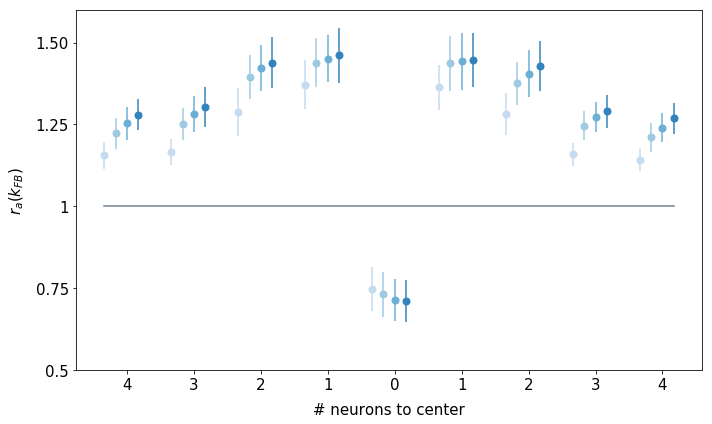

In [21]:
import matplotlib
save_fig = False

distrib_rel = all_rotated_rel[:,:,ptch_size,:].median(dim=1)[0]
error_rel = (all_rotated_rel[:,:,ptch_size,:] - all_rotated_rel[:,:,ptch_size,:].median(dim=1)[0].unsqueeze(dim=1)).abs()
error_rel = error_rel.median(dim=1)[0]

color_fb=['slategrey',cmap1(3),cmap1(2),cmap1(1),cmap1(0)]

ms= 4 

x_or = torch.arange(-6*(ptch_size),6*(ptch_size)+1,6)
all_x = torch.arange(-6*(ptch_size),6*(ptch_size)+4,1)
x_tick_pos = torch.arange(-6*(ptch_size)+2,6*(ptch_size)+1+2,6)
x_tick_label = ['4','3','2','1','0','1','2','3','4']
y_tick_pos = [0.5,0.75,1,1.25,1.50]
y_tick_label = ['0.5','0.75','1','1.25','1.50']

baseline = torch.ones_like(all_x) 
fig = plt.figure(figsize=(10,6))
for i in range(4):
    x = x_or + i
    plt.errorbar(x,distrib_rel[i].cpu().numpy(),yerr=error_rel[i].cpu().numpy(),fmt='o',markersize='7',color=color_fb[i+1],ms=ms)
plt.plot(all_x.numpy(),baseline.numpy(),color='slategrey')
plt.xticks(x_tick_pos,x_tick_label, fontsize=15)
plt.yticks(y_tick_pos,y_tick_label, fontsize=15)
plt.ylim(0.5,1.6)
plt.xlabel('# neurons to center', fontsize=15, labelpad=10)
plt.ylabel(r'$r_{a}(k_{FB})$', fontsize=15, labelpad=10)
plt.tight_layout()
#plt.legend(loc='lower center',bbox_to_anchor=(0.5, -0.5),ncol=5,fontsize=15)
if save_fig == True:
    
    plt.savefig('Savings/Fig/Fig9/Fig9.png', bbox_inches = 'tight', pad_inches = 0, dpi= 400)

plt.show()

## Perfect cocircular map co-circularity map

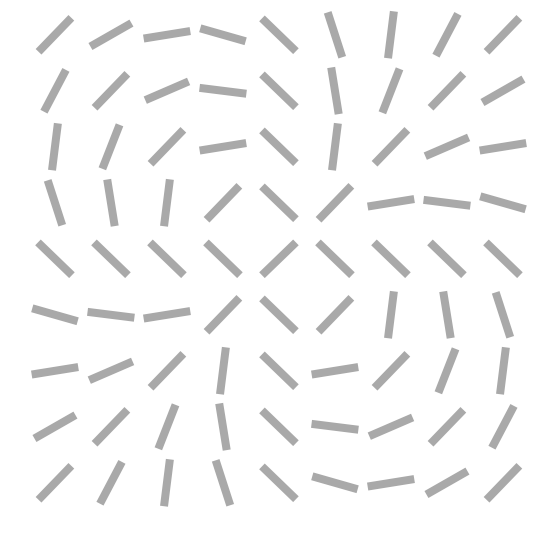

In [22]:
save_fig = False
preferred = torch.zeros_like(original_map)
preferred[ptch_size,ptch_size] = 44
Theta_co,r,d_center = co_circular_AF(preferred,ptch_size)
fig = plt.figure(frameon=True, figsize=(7,7))
currentAxis = plt.Axes(fig, [0., 0., 1., 1.])
currentAxis = OrientationMap(Theta_co,currentAxis,w=8)
currentAxis.set_axis_off()
fig.add_axes(currentAxis)

plt.tight_layout()

if save_fig == True:
    plt.savefig('Savings/Fig/Fig6/perfect_AF.png',\
                bbox_inches = 'tight', pad_inches = 5, dpi= 400)

                

plt.show()

# Supplemental Figures

## Fig S3

pref_orientation=6.00 -- idx:66.612939699278 



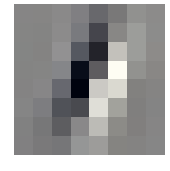

orientation map absolute scale fb=1 pref_orientation=66.61


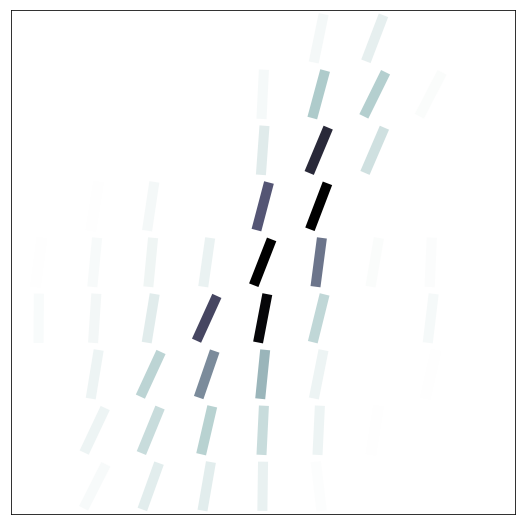

pref_orientation=13.00 -- idx:42.584484083220936 



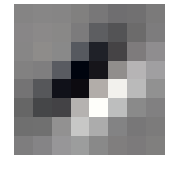

orientation map absolute scale fb=1 pref_orientation=42.58


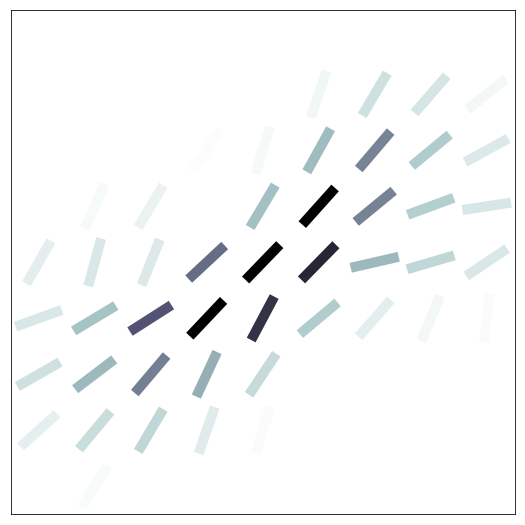

pref_orientation=25.00 -- idx:-0.20751722947150225 



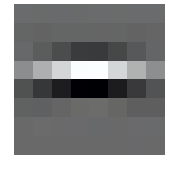

orientation map absolute scale fb=1 pref_orientation=-0.21


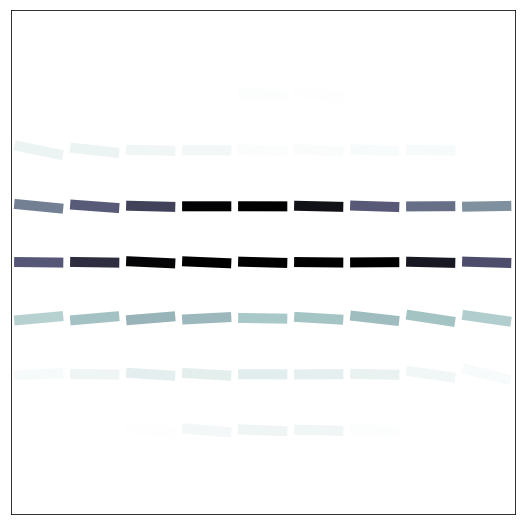

pref_orientation=33.00 -- idx:-28.37059916109051 



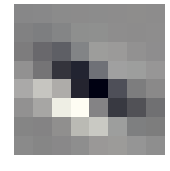

orientation map absolute scale fb=1 pref_orientation=-28.37


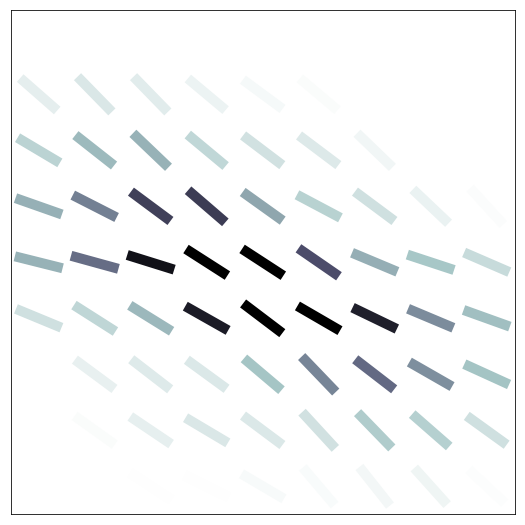

pref_orientation=45.00 -- idx:-64.89012332006577 



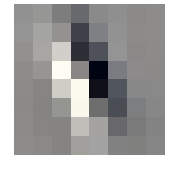

orientation map absolute scale fb=1 pref_orientation=-64.89


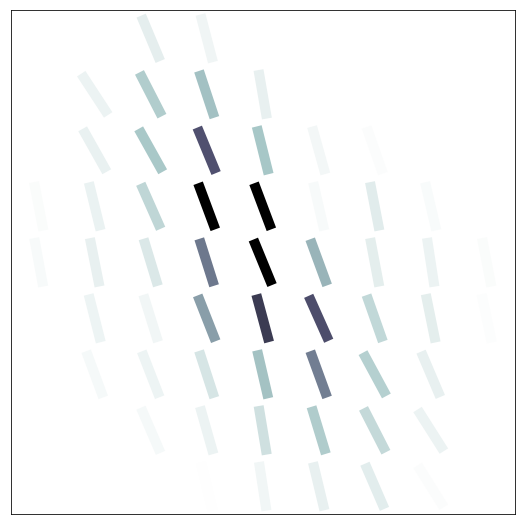

pref_orientation=50.00 -- idx:-89.91360318502664 



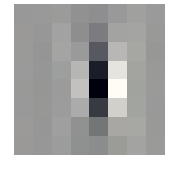

orientation map absolute scale fb=1 pref_orientation=-89.91


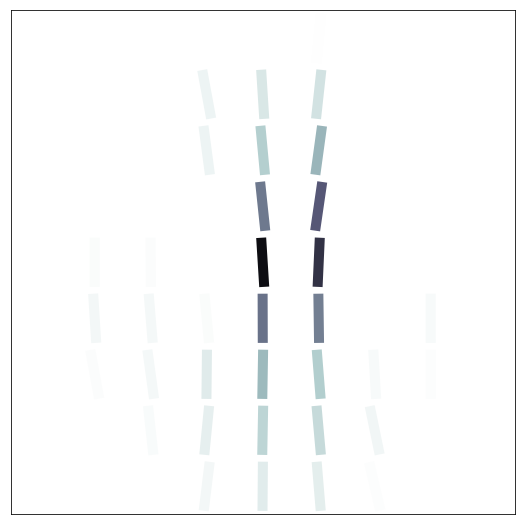

In [23]:
#[14,22]
from matplotlib.ticker import LogLocator
all_absolute_scale = all_result['abs_activity'].cuda()

all_orientation_map = all_result['or_map'].cuda()
all_angle =  all_result['angle_deg'].cuda()
selected_or = [6,13,25,33,45,50]#np.arange(len(all_angle)) #[14]#np.arange(len(all_angle))[14,34]#
save_fig = False
fig_num = ['f','e','a','b','c','d']
for i_fig, idx_pref in enumerate(selected_or): 
    print('pref_orientation={0:.2f} -- idx:{1} \n'.format(idx_pref,all_angle[idx_pref]))
    img2 = make_grid(dico0[idx_pref:idx_pref+1,:,:,:],**grid_param)
    plot_L2 = show(img2.cpu())

    if save_fig == True:
        plot_L2.savefig('Savings/Fig/FigS3/FigS3{0}_filter.png'.format(fig_num[i_fig]), \
                            bbox_inches='tight', pad_inches = 0, dpi= 400)
    plot_L2.show()
    for i in [1]:
        #cmap=plt.get_cmap('pink_r')
        cmap=plt.get_cmap('bone_r')
        print('orientation map absolute scale fb={0} pref_orientation={1:.2f}'.format(i,all_angle[idx_pref]))
        abs_scale = all_absolute_scale[idx_pref,i,:,:]#.div(absolute_scale[i,:,:].max())
        lognorm = colors.Normalize(vmin=0.25, vmax=0.8)
        colorscale = lognorm(abs_scale.cpu().numpy())
        fig = plt.figure(frameon=True, figsize=(7,7))
        currentAxis = plt.Axes(fig, [0., 0., 1., 1.])
        currentAxis = OrientationMap(all_orientation_map[idx_pref,i,:,:],currentAxis, color_map=colorscale,w=10)

        
        fig.add_axes(currentAxis)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=lognorm)
        sm.set_array([])
        '''
        cb = fig.colorbar(sm, ax=currentAxis, extend='both',location='bottom',ticks=[0.3,0.4,0.5,0.6,0.7,0.8])

        cb.ax.set_xticklabels(labels=['0.3','0.4','0.5','0.6','0.7','0.8'] ,fontsize=15)
        cb.set_label('neural response',fontsize=15, labelpad=15)
        '''
        
        plt.tick_params(
            axis='x',       # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,
            right='off', left='off',# ticks along the top edge are off
            labelbottom=False,
            labelleft='off') 
        plt.tick_params(
            axis='y',       # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,  
            right='off', left='off',# ticks along the top edge are off
            labelbottom=False,
            labelleft='off') 
        plt.tight_layout()
        if save_fig == True:
            '''
            plt.savefig('FigSD3/abs_legend.png', \
                        bbox_inches='tight', pad_inches = 0, dpi= 400)
            '''

            plt.savefig('Savings/Fig/FigS3/FigS3{0}.png'.format(fig_num[i_fig]), \
                        bbox_inches='tight', pad_inches = 0, dpi= 400)

        plt.show()
            
        

## Fig S4

pref_orientation=6.00 -- idx:66.612939699278 

phase : -104.66994853804802


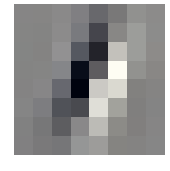

orientation map relati’ve scale fb=1 pref_orientation=6
tensor(0.6998, device='cuda:0')
tensor(1.5320, device='cuda:0')


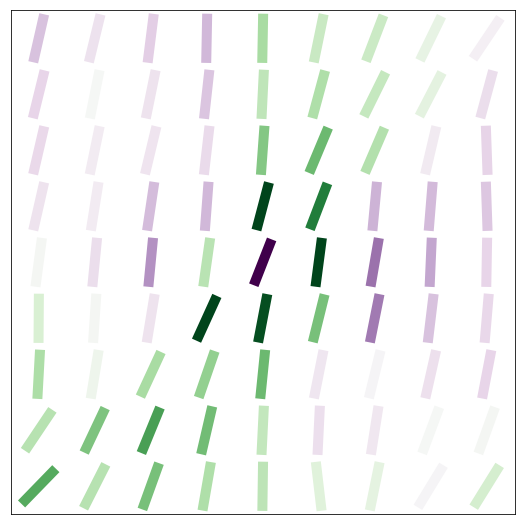

pref_orientation=13.00 -- idx:42.584484083220936 

phase : -100.09923491965439


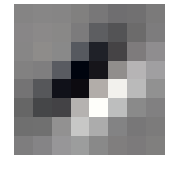

orientation map relati’ve scale fb=1 pref_orientation=13
tensor(0.7822, device='cuda:0')
tensor(1.6303, device='cuda:0')


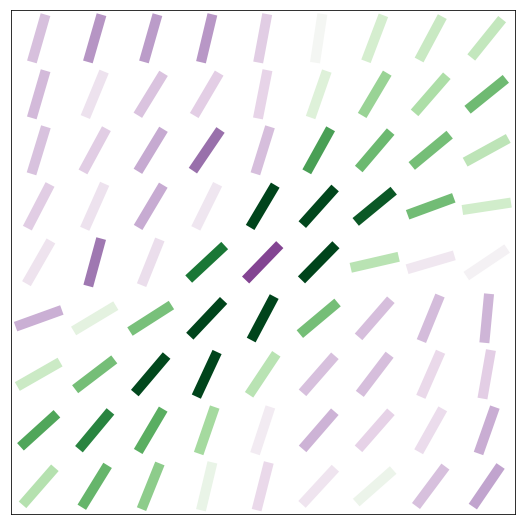

pref_orientation=25.00 -- idx:-0.20751722947150225 

phase : 43.80624923383245


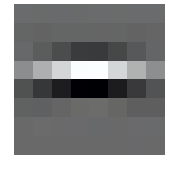

orientation map relati’ve scale fb=1 pref_orientation=25
tensor(0.6922, device='cuda:0')
tensor(1.5414, device='cuda:0')


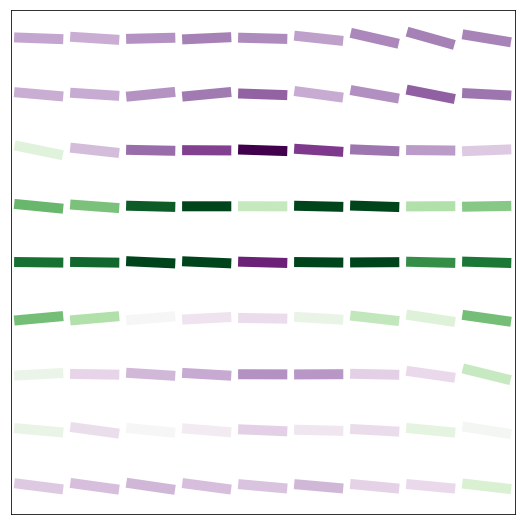

pref_orientation=32.00 -- idx:-21.95921627813218 

phase : -49.369046811051696


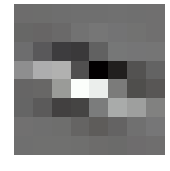

orientation map relati’ve scale fb=1 pref_orientation=32
tensor(0.8100, device='cuda:0')
tensor(1.6534, device='cuda:0')


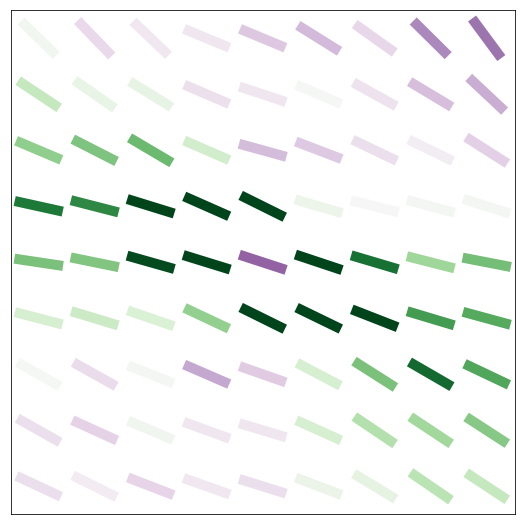

pref_orientation=44.00 -- idx:-63.40614683493385 

phase : -52.31485887892602


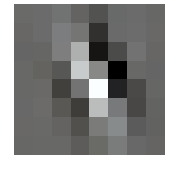

orientation map relati’ve scale fb=1 pref_orientation=44
tensor(0.7095, device='cuda:0')
tensor(1.4510, device='cuda:0')


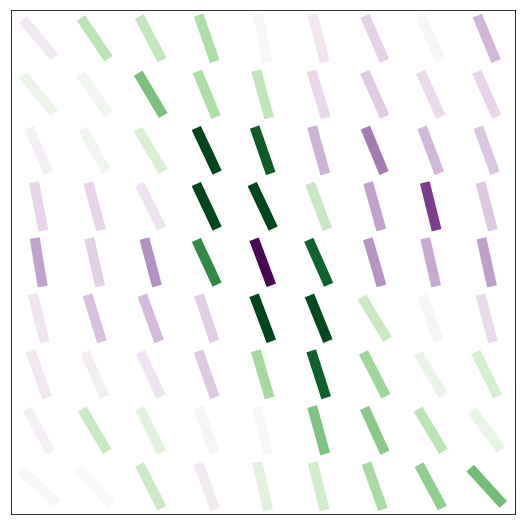

pref_orientation=50.00 -- idx:-89.91360318502664 

phase : 135.84430849156035


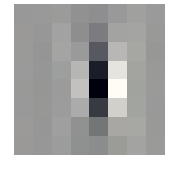

orientation map relati’ve scale fb=1 pref_orientation=50
tensor(0.5808, device='cuda:0')
tensor(1.4869, device='cuda:0')


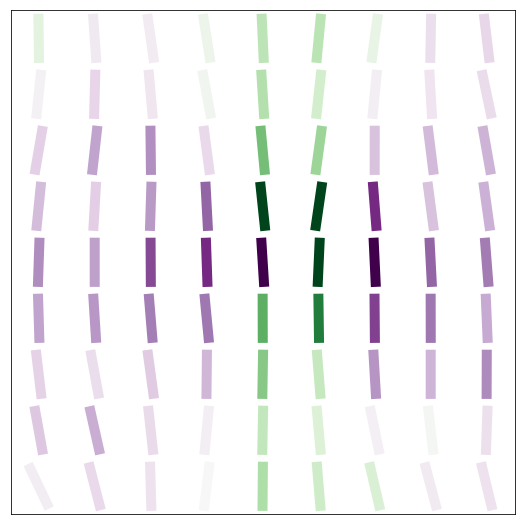

In [24]:
#[14,22]
from matplotlib.ticker import LogLocator
#all_absolute_scale = all_result['abs_activity'].cuda()
all_relative_scale = all_result['rel_activity'].cuda()
all_orientation_map = all_result['or_map'].cuda()
all_angle =  all_result['angle_deg'].cuda()
selected_or = [6,13,25,32,44,50]#np.arange(len(all_angle))
save_fig = False
fig_num = ['f','e','a','b','c','d']
for i_fig, idx_pref in enumerate(selected_or): 
    print('pref_orientation={0:.2f} -- idx:{1} \n'.format(idx_pref,all_angle[idx_pref]))
    print('phase : {0}'.format(sorted_phase[idx_pref]))
    img2 = make_grid(dico0[idx_pref:idx_pref+1,:,:,:],**grid_param)
    plot_L2 = show(img2.cpu())

    if save_fig == True:
        plot_L2.savefig('Savings/Fig/FigS4/FigS4{0}_filter.png'.format(fig_num[i_fig]), \
                            bbox_inches='tight', pad_inches = 0, dpi= 400)
    plot_L2.show()
    i=1
    #cmap=plt.get_cmap('bwr_r')
    cmap=plt.get_cmap('PRGn')
    print('orientation map relati’ve scale fb={0} pref_orientation={1}'.format(i,idx_pref))
    rel_scale = all_relative_scale[idx_pref,i,:,:]
    #print(rel_scale)
    #print(all_absolute_scale[idx_pref,0,:,:])
    #renorm2 = MidPointNorm(midpoint=1,vmin=0.8,vmax=1.8)
    print(rel_scale.min())
    print(rel_scale.max())
    renorm2 = MidPointNorm(midpoint=1,vmin=0.7,vmax=1.3)
    colorscale = renorm2(rel_scale.cpu().numpy())



    fig = plt.figure(frameon=True, figsize=(7,7))
    currentAxis = plt.Axes(fig, [0., 0., 1., 1.])
    currentAxis = OrientationMap(all_orientation_map[idx_pref,i,:,:],currentAxis, color_map=colorscale,w=10)
    #currentAxis.set_axis_off()
    fig.add_axes(currentAxis)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=renorm2)
    sm.set_array([])        
    '''
    cb = plt.colorbar(sm,extend='both',location='bottom')
    cb.ax.set_xticklabels(labels=[r'$0.7$',r'$0.8$',r'$0.9$',r'$1.0$',r'$1.1$',r'$1.2$',r'$1.3$'],fontsize=15)
    #cb.set_label('Relative response w.r.t. no feedback',fontsize=15, labelpad=15)
    cb.ax.set_title('relative response ' + r'($r_{a}(k_{FB})$)',fontsize=15,pad=15)
    '''
#    cb.set_label('relative response ' + r'($r_{a}(k_{FB})$)',fontsize=15, labelpad=15)
    plt.tick_params(
    axis='x',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,
    right='off', left='off',# ticks along the top edge are off
    labelbottom=False,
    labelleft='off')

    plt.tick_params(
    axis='y',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,  
    right='off', left='off',# ticks along the top edge are off
    labelbottom=False,
    labelleft='off') 
    #cb.set_label(size=15)
    plt.tight_layout()

    if save_fig == True:

        plt.savefig('Savings/Fig/FigS4/FigS4{0}.png'.format(fig_num[i_fig]), \
                    bbox_inches='tight', pad_inches = 0.5, dpi= 400)
        '''
        plt.savefig('FigSD4/AF_relative{0:.0f}_fb={1}.png'.format(all_angle[idx_pref],i),\
                    bbox_inches = 'tight', pad_inches = 0, dpi= 400)
        '''
    plt.show()